# Анализ Данных о Взаимодействиях с Рекламными Объявлениями
Проект направлен на анализ данных взаимодействий с рекламными объявлениями на определенной площадке за 6 дней и характеристик рекламных клиентов для выявления ключевых метрик и аномалий.



In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [52]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [53]:
import requests
from urllib.parse import urlencode

def url_ydisk (url):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = url
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url    

## Описание данных
**ads_data.csv** – данные взаимодействий с рекламными объявлениями

- `date` – дата
- `time` – время
- `event` – действие (просмотр/клик)
- `platform` – платформа
- `ad_id` – id объявления
- `client_union_id` – id рекламного кабинета
- `campaign_union_id` – id рекламной кампании
- `ad_cost_type` – тип оплаты
- `ad_cost` – цена
- `has_video` – есть ли видео
- `target_audience_count` – размер аудитории

**ads_clients_data.csv** – характеристики рекламных клиентов

- `date` – дата
- `client_union_id` – id рекламного кабинета
- `community_id` – id сообщества
- `create_date` – дата создания рекламного клиента

In [54]:
ads_clients_data = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/y5sXw1BmyekL4A'))
ads_data = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/O0gM64Lx5ycWOw'))

In [55]:
ads_clients_data.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [56]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


### Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период (округлите до целых).

In [57]:
# Расчитаем количество кликов и просмотров для каждого объявления 
event_counts = ads_data.groupby(['ad_id', 'event'], as_index=False) \
    .agg({'date':'count'}) \
    .rename(columns={'date':'total'})

event_counts.head()

,ad_id,event,total
0,2,click,1
1,2,view,101
2,3,click,3
3,3,view,184
4,1902,click,1


In [58]:
# Преобразуем таблицу, обозначив id объявления как индекс, а колонки - как события, и заполнив значения числом событий 
event_pivot = event_counts.pivot(index='ad_id', columns='event', values='total').fillna(0)
event_pivot.head()

event,click,view
ad_id,,
2,1.0,101.0
3,3.0,184.0
1902,1.0,41.0
2064,0.0,35.0
2132,1.0,58.0


In [59]:
# Расчитаем среднее событий
round(event_pivot.mean())

event
click    113.0
view     923.0
dtype: float64

Ответ: округленное среднее количество показов объявлений за весь период равно 923, а среднее количество кликов на объявления равно 113.

### Давайте посмотрим на распределение показов объявлений.
- По оси x – число показов
- По оси y – доля объявлений с такими показами

In [60]:
#Отфильтруем датафрейм о количестве кликов и просмотров, оставив только показы
views = event_counts.query('event == "view"')
views.head()

,ad_id,event,total
1,2,view,101
3,3,view,184
5,1902,view,41
6,2064,view,35
8,2132,view,58


In [61]:
# Сделаем копию, чтобы избежать предупреждения SettingWithCopyWarning:
views_copy = views.copy()

Прологарифмируем число показов, а затем построим график, чтобы можно было понять форму распределения.

In [62]:
views_copy['total'] = np.log(views_copy['total'])
views_copy.head()

,ad_id,event,total
1,2,view,4.615121
3,3,view,5.214936
5,1902,view,3.713572
6,2064,view,3.555348
8,2132,view,4.060443


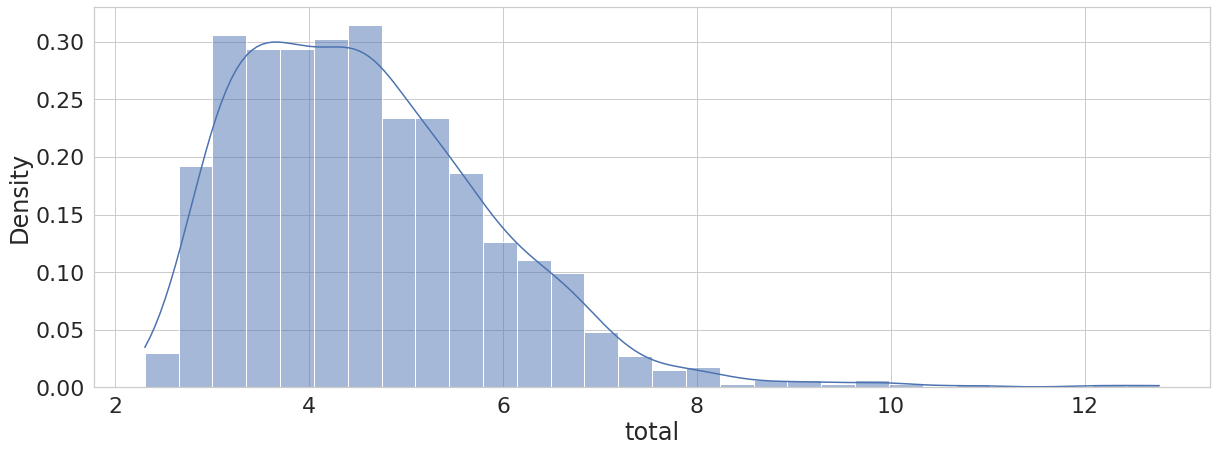

In [63]:
sns.histplot(data=views_copy.total, kde=True, stat='density')

Гистограмма логарифмированных значений показов рекламы имеет унимодальную форму, но демонстрирует положительную асимметрию с длинным правым хвостом. Это указывает на отклонение от нормального распределения. Несмотря на то, что применение логарифма улучшило симметрию данных, распределение все еще **не соответствует нормальному**.

### Теперь нужно найти среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, у которых не было показов (обычное среднее). После этого посчитайте скользящее среднее по полученному результату с окном в 2 элемента.

Вопрос: Какое значение скользящего среднего получим за 6 апреля 2019 года? Округлите ответ до целого числа.

In [64]:
# Расчитаем количество показов на 1 объявление по дням
views_by_day = ads_data.query('event == "view"') \
    .groupby(['ad_id', 'date']) \
    .agg({'time':'count'}) \
    .rename(columns={'time':'views_per_day'})

views_by_day.head()

views_per_day
ad_id date                     
2     2019-04-01             83
      2019-04-02             18
3     2019-04-01            158
      2019-04-02             26
1902  2019-04-03             34

Преобразуем датафрейм, переместив индексы в столбцы, чтобы успешно сгруппировать по дате.

In [65]:
views_by_day = views_by_day.reset_index() 

In [66]:
# Расчитаем среднее количество показов на 1 объявление по дням
mean_views_by_day = views_by_day.groupby('date') \
    .agg({'views_per_day':'mean'}) \
    .rename(columns={'views_per_day':'mean_views'})
mean_views_by_day

,mean_views
date,
2019-04-01,154.482270
2019-04-02,137.786982
2019-04-03,163.952778
2019-04-04,675.901720
2019-04-05,919.109677
2019-04-06,277.122727


In [67]:
# Расчитаем скользящее среднее
rolling_mean_views_by_day = mean_views_by_day.rolling(2).mean() \
    .round() \
    .rename(columns={'mean_views':'rolling_mean_views'})
rolling_mean_views_by_day

,rolling_mean_views
date,
2019-04-01,NaN
2019-04-02,146.0
2019-04-03,151.0
2019-04-04,420.0
2019-04-05,798.0
2019-04-06,598.0


In [68]:
rolling_mean_views_by_day.loc['2019-04-06']

rolling_mean_views    598.0
Name: 2019-04-06, dtype: float64

Ответ: округленное скользящее среднее за 6 апреля 2019 года равно 598.

### Скользящее среднее часто используется для поиска аномалий в данных. Нанесите на один график значения просто среднего количества показов по дням и скользящего среднего на основе этих данных (которое мы получили в прошлом задании).

Посчитайте, в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем. Запишите ответ в формате yyyy-MM-dd

Объединим таблицы с просто средним количества показов по дням и скользящего среднего, чтобы после построить визуализацию значений.

In [69]:
merged_mean_views = pd.merge(mean_views_by_day, rolling_mean_views_by_day, on='date', how='outer')
merged_mean_views

,mean_views,rolling_mean_views
date,,
2019-04-01,154.482270,NaN
2019-04-02,137.786982,146.0
2019-04-03,163.952778,151.0
2019-04-04,675.901720,420.0
2019-04-05,919.109677,798.0
2019-04-06,277.122727,598.0


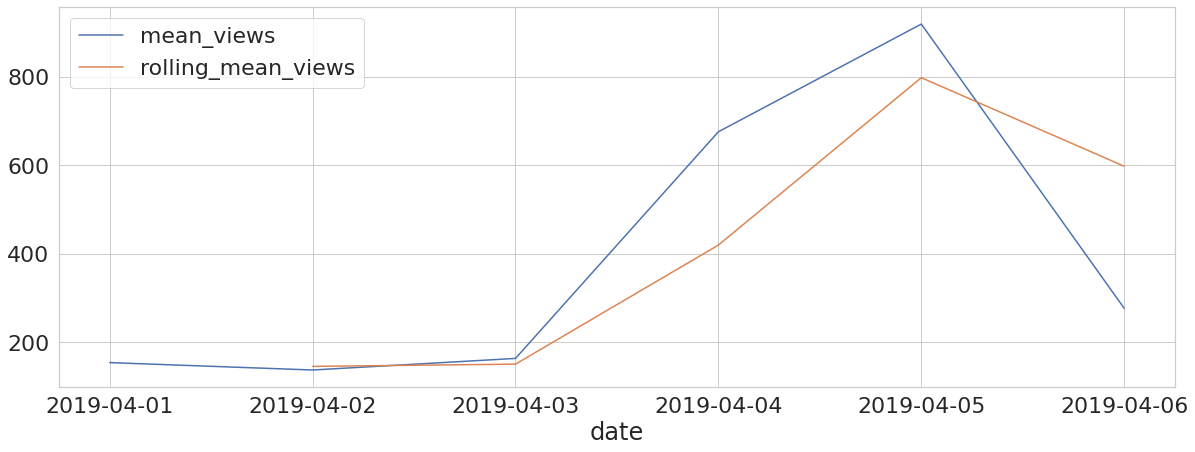

In [70]:
merged_mean_views.plot()

График показывает среднее количество показов по дням (mean_views) и скользящее среднее за период (rolling_mean_views). Видно, что наибольшая разница между этими двумя показателями наблюдается **2019-04-04**. Это можно объяснить резким всплеском значений в этот день, что привело к значительному отклонению от скользящего среднего.

Таким образом, дата с наибольшей разницей между арифметическим средним и скользящим средним по модулю — 2019-04-04.

Несмотря на то, что на графике хорошо видно разницe между средними по модулю, хотелось бы проверить и себя и убедиться. Создадим новый столбец - разницу средних по модулю для каждой даты.

In [71]:
# Разница между арифметическим средним и скользящим средним
merged_mean_views['difference'] = merged_mean_views.mean_views - merged_mean_views.rolling_mean_views

In [72]:
# Найдем наибольшая разницу 
max_diff_mean_rolling = merged_mean_views.difference.max()

In [73]:
# Найдем день, когда наблюдается наибольшая разница
merged_mean_views.query('difference == @max_diff_mean_rolling')

,mean_views,rolling_mean_views,difference
date,,,
2019-04-04,675.90172,420.0,255.90172


Да, действительно наибольшая разница между арифметическим средним и скользящим средним по модулю в 2019-04-04.

### Объедините данные рекламы с данными о рекламных клиентах и найдите среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date).

In [74]:
all_ads_data = ads_data.merge(ads_clients_data, on='client_union_id')
all_ads_data.head()

,date_x,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,date_y,community_id,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2020-05-07,-130129582,2018-12-04


In [75]:
# Преобразуем данные с датами в тип datetime
all_ads_data[['date_x', 'create_date']] = all_ads_data[['date_x', 'create_date']].apply(pd.to_datetime)

In [76]:
# Расчитаем количество дней от даты создания рекламного клиента и запуском рекламного объявления
all_ads_data['difference_date'] = all_ads_data.date_x - all_ads_data.create_date

Расчитаем разницу, соответствующую *первому* запуску рекламы каждого клиента

In [77]:
first_launch = all_ads_data.groupby('client_union_id') \
    .agg({'difference_date':'min'}) \
    .rename(columns={'views_day':'mean_day'})

first_launch.head()

,difference_date
client_union_id,
1,98 days
9,114 days
13,66 days
16,105 days
20,32 days


In [78]:
mean_days_to_first_launch = first_launch.mean() 

In [79]:
mean_days_to_first_launch

difference_date   124 days 09:04:43.532219570
dtype: timedelta64[ns]

Ответ: среднее количество дней от даты создания рекламного клиента (create_date) и первым запуском рекламного объявления этим клиентом (date) равно 124 дням.

### Вычислим конверсию из создания рекламного кабинета в запуск первой рекламы в течение не более 365 дней.

Конверсия – отношение числа клиентов, которые совершили целевое действие (создали рекламу), к общему числу клиентов. Например, 1000 клиентов создали кабинет, но лишь 50 из них запустили рекламу. 

In [80]:
# Кол-во клиентов, у которых запуск первой рекламы произошёл не позже, чем через год после регистрации
clients_with_early_launch = first_launch[first_launch > pd.Timedelta(365, unit='day')].shape[0]     

In [81]:
# Общее кол-во клиентов 
all_clients = ads_clients_data.client_union_id.nunique()

In [82]:
conversion = (clients_with_early_launch / all_clients) * 100

In [83]:
round(conversion, 2)

0.69

Конечная конверсия составляет 0.69, что означает, что 0.69% клиентов запустили первую рекламу в течение года после создания рекламного кабинета.

### Разобъем наших клиентов по промежуткам от создания рекламного кабинета до запуска первого рекламного объявления.

Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). Список промежутков дней для метода pd.cut() – [0, 30, 90, 180, 365]. 

In [84]:
# Перевод промежутков дней в таймдедьту
interval = pd.to_timedelta(['0d', '30d', '90d', '180d', '365d'])

In [85]:
categories = pd.cut(first_launch.difference_date, interval)

In [86]:
# Категории с количеством уникальных клиентов в них (нам нужно 0-30 дней)
unique_in_categories = categories.value_counts()
unique_in_categories

(90 days 00:00:00, 180 days 00:00:00]     396
(30 days 00:00:00, 90 days 00:00:00]      263
(180 days 00:00:00, 365 days 00:00:00]    168
(0 days 00:00:00, 30 days 00:00:00]        11
Name: difference_date, dtype: int64

### Постройте интерактивный барплот, на котором будут показаны категории с количеством уникальных клиентов в них. 

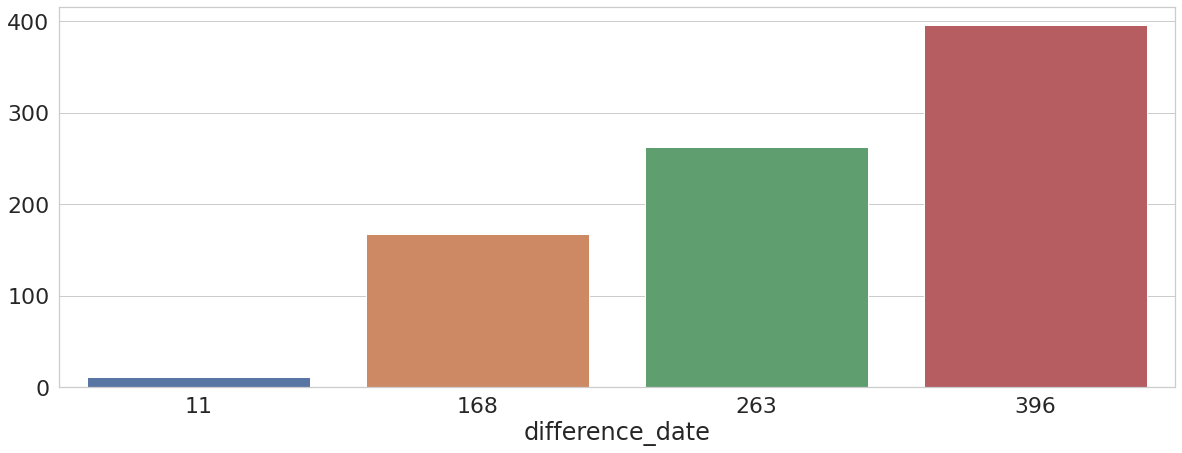

In [87]:
sns.barplot(data=unique_in_categories,
            x=unique_in_categories.index, 
            y=unique_in_categories.values)

In [88]:
unique_in_categories.index = unique_in_categories.index.astype(str)

fig = px.bar(unique_in_categories, x=unique_in_categories.index, y=unique_in_categories.values)
fig.show()